In [1]:

# Importar bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



In [2]:
# Configurar la visualización


%matplotlib inline
sns.set(style="whitegrid")


In [3]:

# Cargar los datos
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')



In [4]:

# Describir los objetivos del estudio

print("Objetivo del estudio:")
print("""
El objetivo de la prueba A/B 'recommender_system_test' es verificar si un nuevo sistema de recomendaciones mejora la conversión 
de los usuarios en las etapas del embudo de ventas (product_page → product_cart → purchase) en comparación con el sistema anterior.
Se espera que al menos un 10% de mejora se produzca en cada etapa durante los 14 días posteriores a la inscripción del usuario.
""")



Objetivo del estudio:

El objetivo de la prueba A/B 'recommender_system_test' es verificar si un nuevo sistema de recomendaciones mejora la conversión 
de los usuarios en las etapas del embudo de ventas (product_page → product_cart → purchase) en comparación con el sistema anterior.
Se espera que al menos un 10% de mejora se produzca en cada etapa durante los 14 días posteriores a la inscripción del usuario.



In [5]:
# Filtrar eventos de marketing aplicables a la región "UE"
marketing_events = marketing_events[marketing_events['regions'] == 'EU']

# Filtrar las fechas de aplicación entre 2020-12-07 y 2021-01-01
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
valid_dates_mask = (marketing_events['start_dt'] >= '2020-12-07') & (marketing_events['finish_dt'] <= '2021-01-01')
marketing_events = marketing_events[valid_dates_mask]

# Verificar que consideramos los primeros 14 días desde que se registraron los usuarios
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
new_users['valid_until'] = new_users['first_date'] + pd.Timedelta(days=14)

# Convertir las fechas de eventos
events['event_dt'] = pd.to_datetime(events['event_dt'])

# Filtrar eventos para asegurarnos de que están dentro de las dos semanas iniciales después del registro
events = events[events['event_dt'] <= new_users['valid_until'].max()]


In [6]:

# Exploración de los datos

marketing_events.info()
print()
new_users.info()
print()
events.info()
print()
participants.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       0 non-null      object        
 1   regions    0 non-null      object        
 2   start_dt   0 non-null      datetime64[ns]
 3   finish_dt  0 non-null      datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 0.0+ bytes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      58703 non-null  object        
 1   first_date   58703 non-null  datetime64[ns]
 2   region       58703 non-null  object        
 3   device       58703 non-null  object        
 4   valid_until  58703 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 2.2+ MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42

In [7]:

# Revisar tipos de datos

print("Tipos de datos antes de la conversión:")
print(new_users.dtypes)
print(events.dtypes)


Tipos de datos antes de la conversión:
user_id                object
first_date     datetime64[ns]
region                 object
device                 object
valid_until    datetime64[ns]
dtype: object
user_id               object
event_dt      datetime64[ns]
event_name            object
details              float64
dtype: object


In [8]:

# 3.2 Comprobar valores ausentes y duplicados

print("\nValores ausentes en cada dataframe:")
print(marketing_events.isnull().sum())
print(new_users.isnull().sum())
print(events.isnull().sum())
print(participants.isnull().sum())



Valores ausentes en cada dataframe:
name         0.0
regions      0.0
start_dt     0.0
finish_dt    0.0
dtype: float64
user_id        0
first_date     0
region         0
device         0
valid_until    0
dtype: int64
user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64
user_id    0
group      0
ab_test    0
dtype: int64


In [9]:
# Verificar los cambios

new_users.info()
print()
events.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      58703 non-null  object        
 1   first_date   58703 non-null  datetime64[ns]
 2   region       58703 non-null  object        
 3   device       58703 non-null  object        
 4   valid_until  58703 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 2.2+ MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 16.2+ MB


In [10]:

# Verificar duplicados

print("\nDuplicados en cada dataframe:")
print("Marketing Events:", marketing_events.duplicated().sum())
print("New Users:", new_users.duplicated().sum())
print("Events:", events.duplicated().sum())
print("Participants:", participants.duplicated().sum())



Duplicados en cada dataframe:
Marketing Events: 0
New Users: 0
Events: 0
Participants: 0


# 4. Análisis Exploratorio de Datos (EDA)

### 4.1 Conversión en las diferentes etapas del embudo

In [11]:
# Unir datos para calcular la conversión
merged = new_users.merge(participants, on='user_id').merge(events, on='user_id')

# Añadir columnas para contar eventos necesarios
merged['product_page'] = merged['event_name'] == 'product_page'
merged['product_cart'] = merged['event_name'] == 'product_cart'
merged['purchase'] = merged['event_name'] == 'purchase'

conversion_stats = merged.groupby('group').agg(
    total_users=('user_id', 'nunique'),
    product_page_conversion=('product_page', 'sum'),
    product_cart_conversion=('product_cart', 'sum'),
    purchase_conversion=('purchase', 'sum')
).reset_index()

conversion_stats['conversion_rate_product_page'] = conversion_stats['product_page_conversion'] / conversion_stats['total_users']
conversion_stats['conversion_rate_product_cart'] = conversion_stats['product_cart_conversion'] / conversion_stats['total_users']
conversion_stats['conversion_rate_purchase'] = conversion_stats['purchase_conversion'] / conversion_stats['total_users']

print("\nTasas de conversión en diferentes etapas del embudo:")
print(conversion_stats)





Tasas de conversión en diferentes etapas del embudo:
  group  total_users  product_page_conversion  product_cart_conversion  \
0     A         7874                    16669                     8023   
1     B         6205                    12292                     6295   

   purchase_conversion  conversion_rate_product_page  \
0                 8619                      2.116967   
1                 6235                      1.980983   

   conversion_rate_product_cart  conversion_rate_purchase  
0                      1.018923                  1.094615  
1                      1.014504                  1.004835  


### Usuarios Únicos que Convirtieron (Para Prueba Z)

In [12]:
# Crear un DataFrame con usuarios únicos que convirtieron
user_conversions = merged.groupby(['group', 'user_id']).agg(
    has_product_page=('product_page', 'any'),
    has_product_cart=('product_cart', 'any'),
    has_purchase=('purchase', 'any')
).reset_index()

# Calcular estadísticas de conversión por usuarios únicos
conversion_stats_unique = user_conversions.groupby('group').agg(
    total_users=('user_id', 'count'),
    users_with_product_page=('has_product_page', 'sum'),
    users_with_product_cart=('has_product_cart', 'sum'),
    users_with_purchase=('has_purchase', 'sum')
).reset_index()

# Calcular tasas de conversión de usuarios únicos
conversion_stats_unique['conversion_rate_product_page'] = conversion_stats_unique['users_with_product_page'] / conversion_stats_unique['total_users']
conversion_stats_unique['conversion_rate_product_cart'] = conversion_stats_unique['users_with_product_cart'] / conversion_stats_unique['total_users']
conversion_stats_unique['conversion_rate_purchase'] = conversion_stats_unique['users_with_purchase'] / conversion_stats_unique['total_users']

print("=== ANÁLISIS 1: USUARIOS ÚNICOS QUE CONVIRTIERON ===")
print(conversion_stats_unique)

print("\n=== ANÁLISIS 2: EVENTOS PROMEDIO POR USUARIO ===")
print(conversion_stats)


=== ANÁLISIS 1: USUARIOS ÚNICOS QUE CONVIRTIERON ===
  group  total_users  users_with_product_page  users_with_product_cart  \
0     A         7874                     5208                     2483   
1     B         6205                     3986                     2037   

   users_with_purchase  conversion_rate_product_page  \
0                 2682                      0.661417   
1                 2008                      0.642385   

   conversion_rate_product_cart  conversion_rate_purchase  
0                      0.315342                  0.340615  
1                      0.328284                  0.323610  

=== ANÁLISIS 2: EVENTOS PROMEDIO POR USUARIO ===
  group  total_users  product_page_conversion  product_cart_conversion  \
0     A         7874                    16669                     8023   
1     B         6205                    12292                     6295   

   purchase_conversion  conversion_rate_product_page  \
0                 8619                      2.

### 4.2 Comprobar si el número de eventos por usuario está distribuido equitativamente

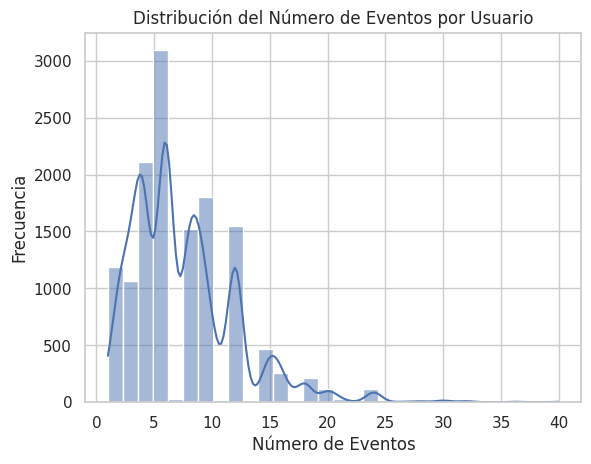

In [13]:
# Grafico de distribucion del numero de eventos por usuario

events_per_user = merged.groupby('user_id')['event_name'].count().reset_index()
sns.histplot(events_per_user['event_name'], bins=30, kde=True)
plt.title('Distribución del Número de Eventos por Usuario')
plt.xlabel('Número de Eventos')
plt.ylabel('Frecuencia')
plt.show()


In [14]:

# 4.3 Verificar si hay usuarios presentes en ambas muestras

users_in_both = set(participants[participants['group'] == 'A']['user_id']).intersection(set(participants[participants['group'] == 'B']['user_id']))
print(f"\nNúmero de usuarios en ambos grupos: {len(users_in_both)}")



Número de usuarios en ambos grupos: 441


### 4.4 Distribución del número de eventos entre los días

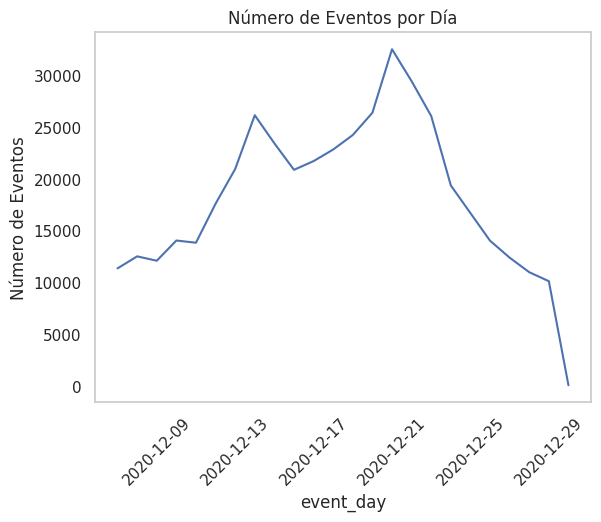

In [15]:
events['event_day'] = events['event_dt'].dt.date
daily_events = events.groupby('event_day').size().reset_index(name='num_events')
sns.lineplot(data=daily_events, x='event_day', y='num_events')
plt.title('Número de Eventos por Día')
plt.xticks(rotation=45)
plt.ylabel('Número de Eventos')
plt.grid()
plt.show()

# 5. Evaluar los resultados de la prueba A/B

In [16]:
# conversion_stats por conversion_stats_unique

# Extraer el número total de usuarios para cada grupo
total_a = conversion_stats_unique.loc[conversion_stats_unique['group'] == 'A', 'total_users'].values[0]
total_b = conversion_stats_unique.loc[conversion_stats_unique['group'] == 'B', 'total_users'].values[0]

# Extraer las tasas de conversión ya calculadas desde el DataFrame
conversion_a = conversion_stats_unique.loc[conversion_stats_unique['group'] == 'A', 'conversion_rate_purchase'].values[0]
conversion_b = conversion_stats_unique.loc[conversion_stats_unique['group'] == 'B', 'conversion_rate_purchase'].values[0]

if total_a > 0 and total_b > 0 and (conversion_a > 0) and (conversion_b > 0):
    success_a = conversion_a * total_a
    success_b = conversion_b * total_b

    variance_a = (conversion_a * (1 - conversion_a) / total_a)
    variance_b = (conversion_b * (1 - conversion_b) / total_b)

    z_score = (conversion_b - conversion_a) / np.sqrt(variance_a + variance_b)
    p_value = stats.norm.sf(abs(z_score)) * 2  # dos colas

    print(f"\nZ-score: {z_score:.4f}, p-value: {p_value:.4f}")

    # Conclusiones basadas en el p-value
    print("\nConclusiones:")
    if p_value < 0.05:
        print("Existen diferencias significativas en las conversiones entre los grupos A y B.")
    else:
        print("No existen diferencias significativas entre las conversiones de los grupos A y B.")
    
    # Interpretación del z-score
    if z_score > 0:
        print(f"Un z-score positivo de {z_score:.4f} indica que la conversión en el grupo B es mayor que en el grupo A.")
    else:
        print(f"Un z-score negativo de {z_score:.4f} indica que la conversión en el grupo A es mayor que en el grupo B.")

    print(f"El p-value de {p_value:.4f} sugiere que la diferencia observada es {'estadísticamente significativa' if p_value < 0.05 else 'no significativa'}.")
else:
    print("No se puede calcular la prueba Z: uno de los grupos no tiene usuarios o las conversiones son inválidas.")



Z-score: -2.1289, p-value: 0.0333

Conclusiones:
Existen diferencias significativas en las conversiones entre los grupos A y B.
Un z-score negativo de -2.1289 indica que la conversión en el grupo A es mayor que en el grupo B.
El p-value de 0.0333 sugiere que la diferencia observada es estadísticamente significativa.
